Imports

In [ ]:
import torch
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install rdkit
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
!pip install -q rdkit-pypi==2021.9.4
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
import torch.nn as nn

In [ ]:
import os
import random
import numpy as np
import torch_geometric
from torch_geometric.data import Data, Dataset,InMemoryDataset, DataLoader,Batch
from torch_geometric.datasets import QM9
import rdkit.Chem as Chem
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops, AllChem
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors
from scipy.stats import pearsonr
from rdkit.Chem import rdFingerprintGenerator, RDKFingerprint
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

Mounted at /content/drive


Prepare datasets and dataloaders for different fingerprint methods

In [ ]:
dataset = QM9(root='data/QM9')
train_dataset = dataset[:10000]
val_dataset = dataset[10000:20000]
test_dataset = dataset[20000:30000]

Extracting data/QM9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [04:01<00:00, 554.58it/s]


Total number of samples: 130831.
Created dataset splits with 10000 training, 10000 validation, 10000 test samples.


Done!


In [ ]:
# morgan fingerprints 
dataset = QM9(root='data/QM9')

class QM9MoleculeSimilarityDataset(InMemoryDataset):
    def __init__(self, dataset, threshold=0.7, positive_ratio=0.5):
        self.dataset = dataset
        self.threshold = threshold
        self.positive_ratio = positive_ratio
        super(QM9MoleculeSimilarityDataset, self).__init__(dataset.root)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['processed_mol_similarity_data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        for i in range(len(self.dataset)):
            data1, data2, label = self.get(i)
            data = Data(data1=data1, data2=data2, y=label)
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


    def __len__(self):
        return len(self.dataset)

    def _get_fingerprint(self, mol):
        return rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)

    def _compute_similarity(self, mol1, mol2):
        fp1 = self._get_fingerprint(mol1)
        fp2 = self._get_fingerprint(mol2)
        return DataStructs.TanimotoSimilarity(fp1, fp2)

    def _get_positive_pair(self, index):
      data1 = self.dataset[index]
      mol1 = self._get_rdkit_mol(data1)
      for _ in range(30):  
          other_index = random.randint(0, len(self.dataset) - 1)
          data2 = self.dataset[other_index]
          mol2 = self._get_rdkit_mol(data2)
          similarity = self._compute_similarity(mol1, mol2)
          if similarity >= self.threshold:
              return self.dataset[index], self.dataset[other_index], torch.tensor([1.0], dtype=torch.float)
      return None, None, None

    def _get_negative_pair(self, index):
        data1 = self.dataset[index]
        mol1 = self._get_rdkit_mol(data1)
        for _ in range(30):  
            other_index = random.randint(0, len(self.dataset) - 1)
            data2 = self.dataset[other_index]
            mol2 = self._get_rdkit_mol(data2)
            similarity = self._compute_similarity(mol1, mol2)
            if similarity < self.threshold:
                return self.dataset[index], self.dataset[other_index], torch.tensor([0.0], dtype=torch.float)
        return None, None, None

    def _get_rdkit_mol(self, data):
      atomic_numbers = data.z.tolist()
      positions = data.pos.tolist()

      mol = Chem.EditableMol(Chem.Mol())
      for z in atomic_numbers:
          mol.AddAtom(Chem.Atom(int(z)))

      mol = mol.GetMol()

      conf = Chem.Conformer(len(atomic_numbers))
      for i, pos in enumerate(positions):
          conf.SetAtomPosition(i, pos)
      mol.AddConformer(conf)
      Chem.SanitizeMol(mol)

      return mol

    def __getitem__(self, index):
        return self.dataset.get(random.randint(0, len(self.dataset) - 1))


    def _compute_similarity(self, mol1, mol2):
      fp1 = self._get_fingerprint(mol1)
      fp2 = self._get_fingerprint(mol2)
      similarity, _ = pearsonr(fp1, fp2)
      return similarity


    def get(self, index):
        is_positive = random.random() < self.positive_ratio
        if is_positive:
            data1, data2, label = self._get_positive_pair(index)
            if data1 is not None and data2 is not None:
                return data1, data2, label
        else:
            data1, data2, label = self._get_negative_pair(index)
            if data1 is not None and data2 is not None:
                return data1, data2, label

        other_index = random.randint(0, len(self.dataset) - 1)
        return self.dataset[index], self.dataset[other_index], torch.tensor([0.0], dtype=torch.float)


In [ ]:
# topological fingerprints
dataset = QM9(root='data/QM9')
class QM9MoleculeSimilarityDatasetTopological(InMemoryDataset):
    def __init__(self, dataset, threshold=0.7, positive_ratio=0.5):
        self.dataset = dataset
        self.threshold = threshold
        self.positive_ratio = positive_ratio
        super(QM9MoleculeSimilarityDatasetTopological, self).__init__(dataset.root)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['processed_mol_similarity_data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        for i in range(len(self.dataset)):
            data1, data2, label = self.get(i)
            data = Data(data1=data1, data2=data2, y=label)
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def __len__(self):
        return len(self.dataset)

    def _get_fingerprint(self, mol):
        return rdFingerprintGenerator.GetFPs([mol])[0]

    def _compute_similarity(self, mol1, mol2):
        fp1 = self._get_fingerprint(mol1)
        fp2 = self._get_fingerprint(mol2)
        return DataStructs.FingerprintSimilarity(fp1, fp2)

    def _get_positive_pair(self, index):
      data1 = self.dataset[index]
      mol1 = self._get_rdkit_mol(data1)
      for _ in range(30):  
          other_index = random.randint(0, len(self.dataset) - 1)
          data2 = self.dataset[other_index]
          mol2 = self._get_rdkit_mol(data2)
          similarity = self._compute_similarity(mol1, mol2)
          if similarity >= self.threshold:
              return self.dataset[index], self.dataset[other_index], torch.tensor([1.0], dtype=torch.float)
      return None, None, None

    def _get_negative_pair(self, index):
        data1 = self.dataset[index]
        mol1 = self._get_rdkit_mol(data1)
        for _ in range(30):  
            other_index = random.randint(0, len(self.dataset) - 1)
            data2 = self.dataset[other_index]
            mol2 = self._get_rdkit_mol(data2)
            similarity = self._compute_similarity(mol1, mol2)
            if similarity < self.threshold:
                return self.dataset[index], self.dataset[other_index], torch.tensor([0.0], dtype=torch.float)
        return None, None, None



    def _get_rdkit_mol(self, data):
      atomic_numbers = data.z.tolist()
      positions = data.pos.tolist()

      mol = Chem.EditableMol(Chem.Mol())
      for z in atomic_numbers:
          mol.AddAtom(Chem.Atom(int(z)))

      mol = mol.GetMol()

      conf = Chem.Conformer(len(atomic_numbers))
      for i, pos in enumerate(positions):
          conf.SetAtomPosition(i, pos)
      mol.AddConformer(conf)
      Chem.SanitizeMol(mol)

      return mol

    def __getitem__(self, index):
        return self.dataset.get(random.randint(0, len(self.dataset) - 1))

    def get(self, index):
        is_positive = random.random() < self.positive_ratio
        if is_positive:
            data1, data2, label = self._get_positive_pair(index)
            if data1 is not None and data2 is not None:
                return data1, data2, label
        else:
            data1, data2, label = self._get_negative_pair(index)
            if data1 is not None and data2 is not None:
                return data1, data2, label

        other_index = random.randint(0, len(self.dataset) - 1)
        return self.dataset[index], self.dataset[other_index], torch.tensor([0.0], dtype=torch.float)

In [ ]:
# path fingerprints
dataset = QM9(root='data/QM9')

class QM9MoleculeSimilarityDatasetPath(InMemoryDataset):
    def __init__(self, dataset, threshold=0.7, positive_ratio=0.5):
        self.dataset = dataset
        self.threshold = threshold
        self.positive_ratio = positive_ratio
        super(QM9MoleculeSimilarityDatasetPath, self).__init__(dataset.root)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['processed_mol_similarity_data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        for i in range(len(self.dataset)):
            data1, data2, label = self.get(i)
            data = Data(data1=data1, data2=data2, y=label)
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def __len__(self):
        return len(self.dataset)

    def _get_fingerprint(self, mol):
        return RDKFingerprint(mol)

    def _compute_similarity(self, mol1, mol2):
        fp1 = self._get_fingerprint(mol1)
        fp2 = self._get_fingerprint(mol2)
        similarity = DataStructs.FingerprintSimilarity(fp1, fp2)
        return similarity



    def _get_positive_pair(self, index):
      data1 = self.dataset[index]
      mol1 = self._get_rdkit_mol(data1)
      for _ in range(30):
          other_index = random.randint(0, len(self.dataset) - 1)
          data2 = self.dataset[other_index]
          mol2 = self._get_rdkit_mol(data2)
          similarity = self._compute_similarity(mol1, mol2)
          if similarity >= self.threshold:
              return self.dataset[index], self.dataset[other_index], torch.tensor([1.0], dtype=torch.float)
      return None, None, None

    def _get_negative_pair(self, index):
        data1 = self.dataset[index]
        mol1 = self._get_rdkit_mol(data1)
        for _ in range(30):  
            other_index = random.randint(0, len(self.dataset) - 1)
            data2 = self.dataset[other_index]
            mol2 = self._get_rdkit_mol(data2)
            similarity = self._compute_similarity(mol1, mol2)
            if similarity < self.threshold:
                return self.dataset[index], self.dataset[other_index], torch.tensor([0.0], dtype=torch.float)
        return None, None, None



    def _get_rdkit_mol(self, data):
      atomic_numbers = data.z.tolist()
      positions = data.pos.tolist()

      mol = Chem.EditableMol(Chem.Mol())
      for z in atomic_numbers:
          mol.AddAtom(Chem.Atom(int(z)))

      mol = mol.GetMol()

      conf = Chem.Conformer(len(atomic_numbers))
      for i, pos in enumerate(positions):
          conf.SetAtomPosition(i, pos)
      mol.AddConformer(conf)
      Chem.SanitizeMol(mol)

      return mol

    def __getitem__(self, index):
        return self.dataset.get(random.randint(0, len(self.dataset) - 1))

    def _compute_similarity(self, mol1, mol2):
      fp1 = self._get_fingerprint(mol1)
      fp2 = self._get_fingerprint(mol2)
      similarity = DataStructs.FingerprintSimilarity(fp1, fp2)
      return similarity


    def get(self, index):
        is_positive = random.random() < self.positive_ratio
        if is_positive:
            data1, data2, label = self._get_positive_pair(index)
            if data1 is not None and data2 is not None:
                return data1, data2, label
        else:
            data1, data2, label = self._get_negative_pair(index)
            if data1 is not None and data2 is not None:
                return data1, data2, label

        other_index = random.randint(0, len(self.dataset) - 1)
        return self.dataset[index], self.dataset[other_index], torch.tensor([0.0], dtype=torch.float)

In [ ]:
#torsion fingerprints
dataset = QM9(root='data/QM9')

class QM9MoleculeSimilarityDatasetTorsion(InMemoryDataset):
    def __init__(self, dataset, threshold=0.7, positive_ratio=0.5):
        self.dataset = dataset
        self.threshold = threshold
        self.positive_ratio = positive_ratio
        super(QM9MoleculeSimilarityDatasetTorsion, self).__init__(dataset.root)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['processed_mol_similarity_data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        for i in range(len(self.dataset)):
            data1, data2, label = self.get(i)
            data = Data(data1=data1, data2=data2, y=label)
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def __len__(self):
        return len(self.dataset)

    def _get_fingerprint(self, mol):
        return rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=2048)

    def _compute_similarity(self, mol1, mol2):
        fp1 = self._get_fingerprint(mol1)
        fp2 = self._get_fingerprint(mol2)
        return DataStructs.TanimotoSimilarity(fp1, fp2)


    def _get_positive_pair(self, index):
      data1 = self.dataset[index]
      mol1 = self._get_rdkit_mol(data1)
      for _ in range(30): 
          other_index = random.randint(0, len(self.dataset) - 1)
          data2 = self.dataset[other_index]
          mol2 = self._get_rdkit_mol(data2)
          similarity = self._compute_similarity(mol1, mol2)
          if similarity >= self.threshold:
              return self.dataset[index], self.dataset[other_index], torch.tensor([1.0], dtype=torch.float)
      return None, None, None

    def _get_negative_pair(self, index):
        data1 = self.dataset[index]
        mol1 = self._get_rdkit_mol(data1)
        for _ in range(30): 
            other_index = random.randint(0, len(self.dataset) - 1)
            data2 = self.dataset[other_index]
            mol2 = self._get_rdkit_mol(data2)
            similarity = self._compute_similarity(mol1, mol2)
            if similarity < self.threshold:
                return self.dataset[index], self.dataset[other_index], torch.tensor([0.0], dtype=torch.float)
        return None, None, None



    def _get_rdkit_mol(self, data):
      atomic_numbers = data.z.tolist()
      positions = data.pos.tolist()

      mol = Chem.EditableMol(Chem.Mol())
      for z in atomic_numbers:
          mol.AddAtom(Chem.Atom(int(z)))

      mol = mol.GetMol()

      conf = Chem.Conformer(len(atomic_numbers))
      for i, pos in enumerate(positions):
          conf.SetAtomPosition(i, pos)
      mol.AddConformer(conf)
      Chem.SanitizeMol(mol)

      return mol
    
    def _compute_similarity(self, mol1, mol2):
      fp1 = self._get_fingerprint(mol1)
      fp2 = self._get_fingerprint(mol2)
      similarity, _ = pearsonr(fp1, fp2)
      return similarity


    
    def __getitem__(self, index):
        return self.dataset.get(random.randint(0, len(self.dataset) - 1))


    def get(self, index):
        is_positive = random.random() < self.positive_ratio
        if is_positive:
            data1, data2, label = self._get_positive_pair(index)
            if data1 is not None and data2 is not None:
                return data1, data2, label
        else:
            data1, data2, label = self._get_negative_pair(index)
            if data1 is not None and data2 is not None:
                return data1, data2, label

        other_index = random.randint(0, len(self.dataset) - 1)
        return self.dataset[index], self.dataset[other_index], torch.tensor([0.0], dtype=torch.float)

In [ ]:
# avalon fingerprints 
dataset = QM9(root='data/QM9')

class QM9MoleculeSimilarityDatasetAvalon(InMemoryDataset):
    def __init__(self, dataset, threshold=0.7, positive_ratio=0.5):
        self.dataset = dataset
        self.threshold = threshold
        self.positive_ratio = positive_ratio
        super(QM9MoleculeSimilarityDatasetAvalon, self).__init__(dataset.root)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['processed_mol_similarity_data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        for i in range(len(self.dataset)):
            data1, data2, label = self.get(i)
            data = Data(data1=data1, data2=data2, y=label)
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


    def __len__(self):
        return len(self.dataset)

    def _get_fingerprint(self, mol):
        return GetAvalonFP(mol)

    def _compute_similarity(self, mol1, mol2):
        fp1 = self._get_fingerprint(mol1)
        fp2 = self._get_fingerprint(mol2)
        return DataStructs.TanimotoSimilarity(fp1, fp2)

    def _get_positive_pair(self, index):
      data1 = self.dataset[index]
      mol1 = self._get_rdkit_mol(data1)
      for _ in range(30):  
          other_index = random.randint(0, len(self.dataset) - 1)
          data2 = self.dataset[other_index]
          mol2 = self._get_rdkit_mol(data2)
          similarity = self._compute_similarity(mol1, mol2)
          if similarity >= self.threshold:
              return self.dataset[index], self.dataset[other_index], torch.tensor([1.0], dtype=torch.float)
      return None, None, None

    def _get_negative_pair(self, index):
        data1 = self.dataset[index]
        mol1 = self._get_rdkit_mol(data1)
        for _ in range(30):  
            other_index = random.randint(0, len(self.dataset) - 1)
            data2 = self.dataset[other_index]
            mol2 = self._get_rdkit_mol(data2)
            similarity = self._compute_similarity(mol1, mol2)
            if similarity < self.threshold:
                return self.dataset[index], self.dataset[other_index], torch.tensor([0.0], dtype=torch.float)
        return None, None, None

    def _get_rdkit_mol(self, data):
      atomic_numbers = data.z.tolist()
      positions = data.pos.tolist()

      mol = Chem.EditableMol(Chem.Mol())
      for z in atomic_numbers:
          mol.AddAtom(Chem.Atom(int(z)))

      mol = mol.GetMol()

      conf = Chem.Conformer(len(atomic_numbers))
      for i, pos in enumerate(positions):
          conf.SetAtomPosition(i, pos)
      mol.AddConformer(conf)
      Chem.SanitizeMol(mol)

      return mol

    def __getitem__(self, index):
        return self.dataset.get(random.randint(0, len(self.dataset) - 1))


    def _compute_similarity(self, mol1, mol2):
      fp1 = self._get_fingerprint(mol1)
      fp2 = self._get_fingerprint(mol2)
      similarity, _ = pearsonr(fp1, fp2)
      return similarity


    def get(self, index):
        is_positive = random.random() < self.positive_ratio
        if is_positive:
            data1, data2, label = self._get_positive_pair(index)
            if data1 is not None and data2 is not None:
                return data1, data2, label
        else:
            data1, data2, label = self._get_negative_pair(index)
            if data1 is not None and data2 is not None:
                return data1, data2, label
        other_index = random.randint(0, len(self.dataset) - 1)
        return self.dataset[index], self.dataset[other_index], torch.tensor([0.0], dtype=torch.float)


Methods for visualisations

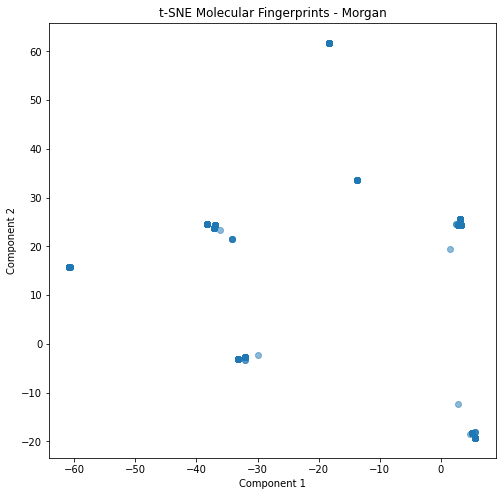

In [ ]:
#! pip install rdkit scikit-learn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def get_fingerprints(dataset, num_samples):
    fingerprints = []
    for i in range(num_samples):
        data = dataset[random.randint(0, len(dataset) - 1)]
        mol = dataset._get_rdkit_mol(data)
        fingerprint = np.array(dataset._get_fingerprint(mol), dtype=np.float32)
        fingerprints.append(fingerprint)
    return np.array(fingerprints)

def visualize_tsne(fingerprints):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(fingerprints)
    plt.figure(figsize=(8, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title('t-SNE Molecular Fingerprints - Morgan')
    plt.show()

def get_fingerprints(dataset, num_samples):
    fingerprints = []
    #similarity_dataset = QM9MoleculeSimilarityDataset(dataset)  
    for i in range(num_samples):
        data = dataset[random.randint(0, len(dataset) - 1)]
        mol = similarity_dataset._get_rdkit_mol(data)
        fingerprint = np.array(similarity_dataset._get_fingerprint(mol), dtype=np.float32)
        fingerprints.append(fingerprint)
    return np.stack(fingerprints, axis=0)

#similarity_dataset = QM9MoleculeSimilarityDataset(dataset)
num_samples = 10000
fingerprints = get_fingerprints(dataset, num_samples)
visualize_tsne(fingerprints)

<ipython-input-29-cf07050e97a3>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], s=10, cmap='Spectral', alpha=0.2)


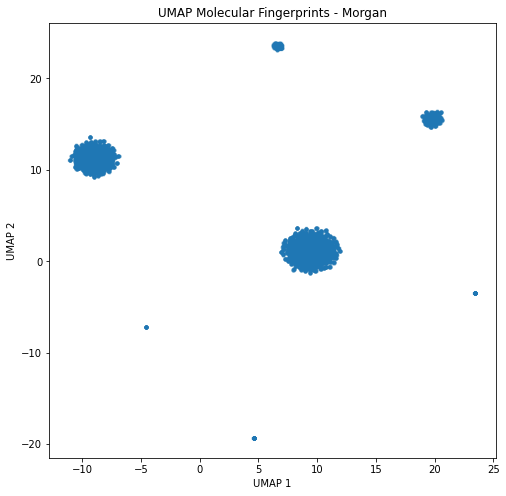

In [ ]:
#!pip install umap-learn
import umap
import matplotlib.pyplot as plt

def visualize_fingerprints_umap(fingerprints):
    reducer = umap.UMAP()
    embeddings = reducer.fit_transform(fingerprints)

    plt.figure(figsize=(8, 8))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], s=10, cmap='Spectral', alpha=0.2)
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('UMAP Molecular Fingerprints - Morgan')
    plt.show()

num_samples = 10000
similarity_dataset = QM9MoleculeSimilarityDataset(dataset)
fingerprints = get_fingerprints(similarity_dataset, num_samples)

visualize_fingerprints_umap(fingerprints)

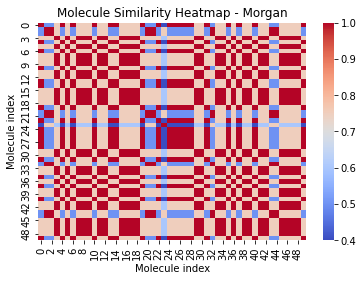

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#similarity_dataset = QM9MoleculeSimilarityDataset(dataset,threshold=0.7, positive_ratio=0.5)

num_samples = 50 
sample_indices = np.random.choice(len(dataset), num_samples, replace=False)

similarity_matrix = np.zeros((num_samples, num_samples))

for i in range(num_samples):
    for j in range(num_samples):
        mol1 = similarity_dataset._get_rdkit_mol(dataset[sample_indices[i]])
        mol2 = similarity_dataset._get_rdkit_mol(dataset[sample_indices[j]])
        similarity_matrix[i, j] = similarity_dataset._compute_similarity(mol1, mol2)

sns.heatmap(similarity_matrix, cmap="coolwarm")
plt.xlabel("Molecule index")
plt.ylabel("Molecule index")
plt.title("Molecule Similarity Heatmap - Morgan")
plt.show()


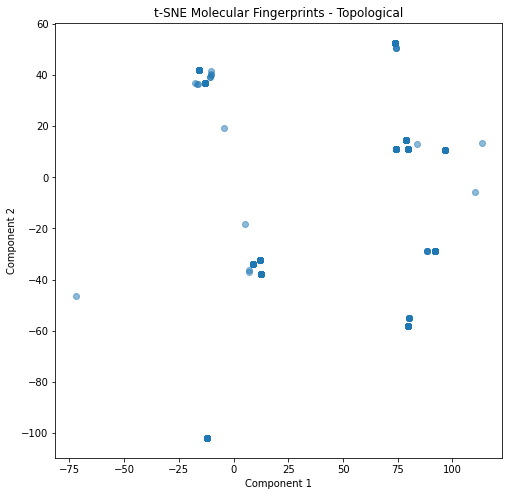

In [ ]:
similarity_dataset = QM9MoleculeSimilarityDatasetTopological(dataset)

num_samples = 10000
fingerprints = get_fingerprints(dataset, num_samples)


# Visualize the fingerprints using t-SNE
visualize_tsne(fingerprints)

<ipython-input-30-76ae78fa853e>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], s=10, cmap='Spectral', alpha=0.2)


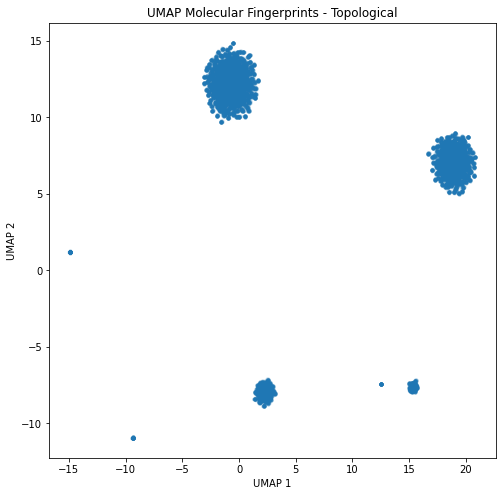

In [ ]:
#similarity_dataset = QM9MoleculeSimilarityDataset(dataset)
fingerprints = get_fingerprints(similarity_dataset, num_samples)

visualize_fingerprints_umap(fingerprints)

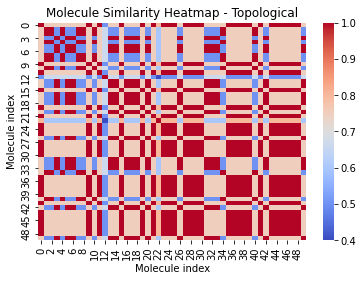

In [ ]:
#similarity_dataset = QM9MoleculeSimilarityDataset(dataset,threshold=0.7, positive_ratio=0.5)

num_samples = 50 
sample_indices = np.random.choice(len(dataset), num_samples, replace=False)

similarity_matrix = np.zeros((num_samples, num_samples))

for i in range(num_samples):
    for j in range(num_samples):
        mol1 = similarity_dataset._get_rdkit_mol(dataset[sample_indices[i]])
        mol2 = similarity_dataset._get_rdkit_mol(dataset[sample_indices[j]])
        similarity_matrix[i, j] = similarity_dataset._compute_similarity(mol1, mol2)

sns.heatmap(similarity_matrix, cmap="coolwarm")
plt.xlabel("Molecule index")
plt.ylabel("Molecule index")
plt.title("Molecule Similarity Heatmap - Topological")
plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-19-7ac3cccd7804>:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], s=10, cmap='Spectral', alpha=0.2)


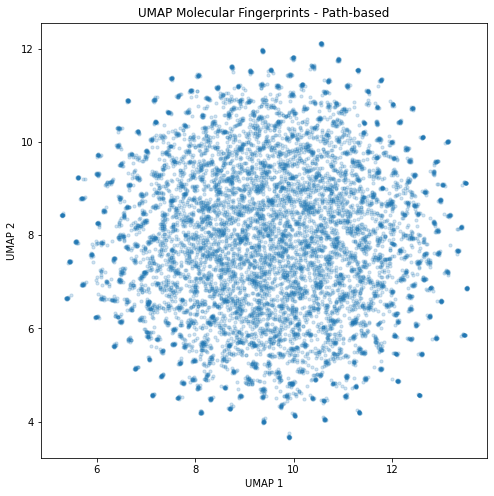

In [ ]:
num_samples = 10000
#similarity_dataset = QM9MoleculeSimilarityDataset(dataset)
fingerprints = get_fingerprints(similarity_dataset, num_samples)
visualize_fingerprints_umap(fingerprints)

<ipython-input-25-adb5dfdf1b03>:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], s=10, cmap='Spectral', alpha=0.2)


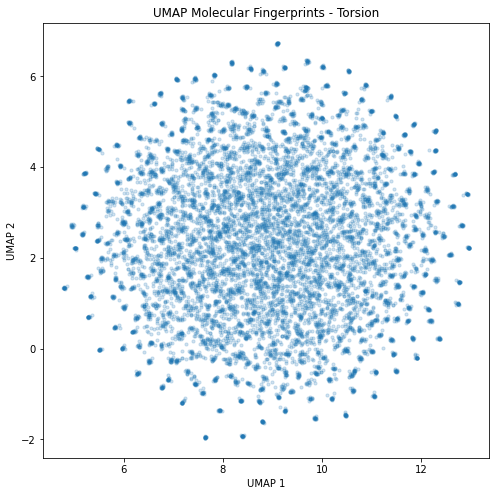

In [ ]:
num_samples = 10000
similarity_dataset = QM9MoleculeSimilarityDatasetTorsion(dataset)
fingerprints = get_fingerprints(similarity_dataset, num_samples)
visualize_fingerprints_umap(fingerprints)

<ipython-input-12-50c45672fc98>:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings[:, 0], embeddings[:, 1], s=10, cmap='Spectral', alpha=0.2)


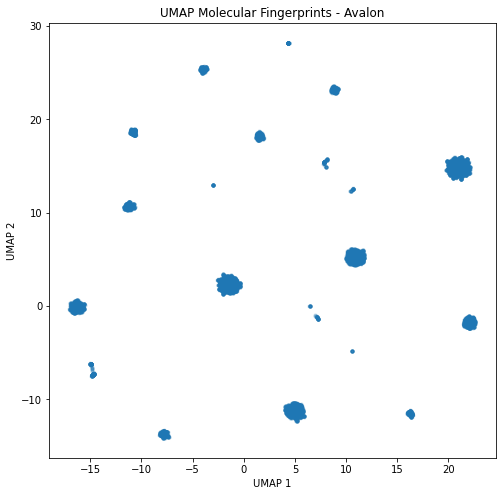

In [ ]:
num_samples = 10000
#similarity_dataset = QM9MoleculeSimilarityDatasetAvalon(dataset)
fingerprints = get_fingerprints(similarity_dataset, num_samples)
visualize_fingerprints_umap(fingerprints)

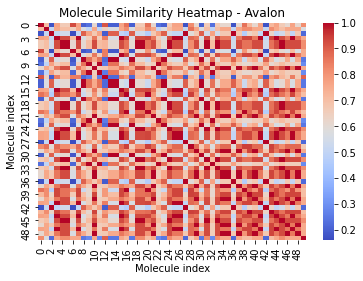

In [ ]:
num_samples = 50
sample_indices = np.random.choice(len(dataset), num_samples, replace=False)
similarity_matrix = np.zeros((num_samples, num_samples))
for i in range(num_samples):
    for j in range(num_samples):
        mol1 = similarity_dataset._get_rdkit_mol(dataset[sample_indices[i]])
        mol2 = similarity_dataset._get_rdkit_mol(dataset[sample_indices[j]])
        similarity_matrix[i, j] = similarity_dataset._compute_similarity(mol1, mol2)

sns.heatmap(similarity_matrix, cmap="coolwarm")
plt.xlabel("Molecule index")
plt.ylabel("Molecule index")
plt.title("Molecule Similarity Heatmap - Avalon")
plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


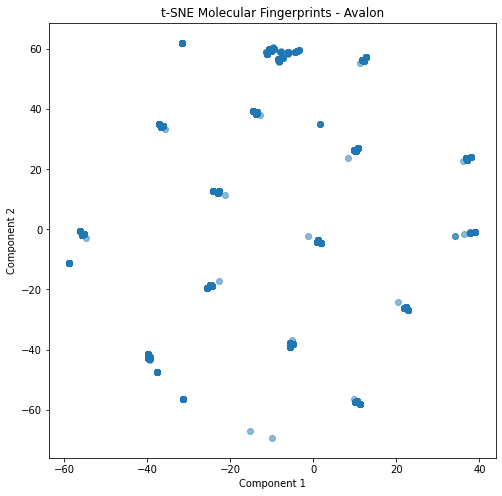

In [ ]:
#similarity_dataset = QM9MoleculeSimilarityDataset(dataset)
num_samples = 10000
fingerprints = get_fingerprints(dataset, num_samples)
visualize_tsne(fingerprints)